**Apartment rental offers in Germany**
> Rental offers scraped from Germany biggest real estate online plattform 

# STEPS
1. [Import libraries](#Import_libraries)
2. [Load data and look at data](#Load_data)
    1. [Null items](#Null_items)
    2. [Duplicate](#Duplicate)
    3. [Outliers](#Outliers)
3. [Features](#Features)

<a id="Import_libraries"></a>
# Import libraries

In [1]:
#!pip install pyspark

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import PandasUDFType
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, FloatType

In [3]:
# Create SparkSession
spark = SparkSession.builder.appName('Apartment rental offers in Germany').getOrCreate()

In [4]:
spark.version

'3.2.1'

<a id="Load_data"></a>
# Load data and look at data

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
s = time.time()
# load the dataset and create sprk dataframe
df_s = spark.read.csv('immo_data.csv',inferSchema=True,header=True)
# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table
print(f'pyspark {time.time()-s} second')
df_s.limit(3).toPandas()

pyspark 6.215826511383057 second


,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245,central_heating,ONE_YEAR_FREE,NA,FALSE,FALSE,6,4.62,10,840,1965,96107057,1,oil,FALSE,Nordrhein_Westfalen,TRUE,2,595,244,86,Dortmund,well_kept,normal,NA,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,FALSE,4,ground_floor,44269,4,181.4,1,3,4,TRUE,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,None,None,None,None,None,None
1,Zur Wohnung gehört ein 10 m großer Keller. Ein...,NA,NA,NA,NA,NA,May19,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Rheinland_Pfalz,134,self_contained_central_heating,ONE_YEAR_FREE,NA,FALSE,TRUE,8,3.47,10,NA,1871,111378734,2,gas,FALSE,Rheinland_Pfalz,FALSE,1,800,NA,89,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NA,FALSE,5,ground_floor,67459,3,NA,NA,NA,3,FALSE,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,None,None,None,None,None,None,None


In [7]:
s = time.time()
df_p = pd.read_csv("immo_data.csv")
print(f'pandas {time.time()-s} second')
df_p.head(3)

pandas 3.425577402114868 second


,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.0,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.0,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.0,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.0,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.0,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.8,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19


In [8]:
print(df_s.count(), len(df_s.columns))

1877955 49


In [9]:
df_p.shape

(268850, 49)

In [10]:
df_s.printSchema()

root
 |-- regio1: string (nullable = true)
 |-- serviceCharge: string (nullable = true)
 |-- heatingType: string (nullable = true)
 |-- telekomTvOffer: string (nullable = true)
 |-- telekomHybridUploadSpeed: string (nullable = true)
 |-- newlyConst: string (nullable = true)
 |-- balcony: string (nullable = true)
 |-- picturecount: string (nullable = true)
 |-- pricetrend: string (nullable = true)
 |-- telekomUploadSpeed: string (nullable = true)
 |-- totalRent: string (nullable = true)
 |-- yearConstructed: string (nullable = true)
 |-- scoutId: string (nullable = true)
 |-- noParkSpaces: string (nullable = true)
 |-- firingTypes: string (nullable = true)
 |-- hasKitchen: string (nullable = true)
 |-- geo_bln: string (nullable = true)
 |-- cellar: string (nullable = true)
 |-- yearConstructedRange: string (nullable = true)
 |-- baseRent: string (nullable = true)
 |-- houseNumber: string (nullable = true)
 |-- livingSpace: string (nullable = true)
 |-- geo_krs: string (nullable = true)


In [11]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

<a id="Null_items"></a>
# Null items

In [12]:
for col in df_p.columns:
    if df_p[col].isnull().sum()/len(df_p[col])*100 > 0 :
        print(col," =>", df_p[col].isnull().sum()/len(df_p[col])*100)

serviceCharge  => 2.5698344801934163
heatingType  => 16.68439650362656
telekomTvOffer  => 12.132787799888414
telekomHybridUploadSpeed  => 83.25460293844151
pricetrend  => 0.6814208666542682
telekomUploadSpeed  => 12.407662265203644
totalRent  => 15.070485400781106
yearConstructed  => 21.218151385530966
noParkSpaces  => 65.38887855681607
firingTypes  => 21.188023061186534
yearConstructedRange  => 21.218151385530966
houseNumber  => 26.415473312255905
condition  => 25.474800074390924
interiorQual  => 41.90626743537288
petsAllowed  => 42.6159568532639
streetPlain  => 26.413613539148223
typeOfFlat  => 13.618746512925423
thermalChar  => 39.6153989213316
floor  => 19.084619676399477
numberOfFloors  => 36.35186907197322
description  => 7.3449879114748
facilities  => 19.6853263901804
heatingCosts  => 68.1911846754696
energyEfficiencyClass  => 71.06676585456574
lastRefurbish  => 69.97917054119397
electricityBasePrice  => 82.57541379951647
electricityKwhPrice  => 82.57541379951647


In [13]:
null = ("telekomHybridUploadSpeed", "noParkSpaces", "interiorQual", "petsAllowed", "heatingCosts", "energyEfficiencyClass", "lastRefurbish", "electricityBasePrice", "electricityKwhPrice")

In [14]:
s = time.time()
df_s.drop(*null)
print(f'pyspark {time.time()-s} second')

pyspark 0.02932000160217285 second


In [15]:
s = time.time()
df_p.drop(columns=list(null), axis=1, inplace=True)
print(f'pandas {time.time()-s} second')

pandas 0.05294179916381836 second


In [16]:
def fillnapy():
    df_s.na.fill(df_p.serviceCharge.median(), "serviceCharge")
    df_s.na.fill(df_p.heatingType.mode()[0], "heatingType")
    df_s.na.fill("NONE", "telekomTvOffer")
    df_s.na.fill(df_p.pricetrend.median(), "pricetrend")
    df_s.na.fill(df_p.telekomUploadSpeed.median(), "telekomUploadSpeed")
    df_s.na.fill(df_p.totalRent.median(), "totalRent")
    df_s.na.fill(df_p.yearConstructed.median(), "yearConstructed")
    df_s.na.fill(df_p.firingTypes.mode()[0], "firingTypes")
    df_s.na.fill(df_p.yearConstructedRange.median(), "yearConstructedRange")
    df_s.na.fill(0, "houseNumber")
    df_s.na.fill(df_p.condition.mode()[0], "condition")
    df_s.na.fill(df_p.streetPlain.mode()[0], "streetPlain")
    df_s.na.fill(df_p.typeOfFlat.mode()[0], "typeOfFlat")
    df_s.na.fill(df_p.thermalChar.median(), "thermalChar")
    df_s.na.fill(df_p.floor.median(), "floor")
    df_s.na.fill(df_p.numberOfFloors.median(), "numberOfFloors")
    df_s.na.fill('nothing', "description")
    df_s.na.fill('nothing', "facilities")
    return time.time()

In [17]:
s = time.time()
time2 = fillnapy()
print(f'pyspark {time2 - s} second')

pyspark 0.612891435623169 second


In [18]:
def fillna():
    df_p.serviceCharge.fillna(df_p.serviceCharge.median(), inplace=True)
    df_p.heatingType.fillna(df_p.heatingType.mode()[0], inplace=True)
    df_p.telekomTvOffer.fillna("NONE", inplace=True)
    df_p.pricetrend.fillna(df_p.pricetrend.median(), inplace=True)
    df_p.telekomUploadSpeed.fillna(df_p.telekomUploadSpeed.median(), inplace=True)
    df_p.totalRent.fillna(df_p.totalRent.median(), inplace=True)
    df_p.yearConstructed.fillna(df_p.yearConstructed.median(), inplace=True)
    df_p.firingTypes.fillna(df_p.firingTypes.mode()[0], inplace=True)
    df_p.yearConstructedRange.fillna(df_p.yearConstructedRange.median(), inplace=True)
    df_p.houseNumber.fillna(0, inplace=True)
    df_p.condition.fillna(df_p.condition.mode()[0], inplace=True)
    df_p.streetPlain.fillna(df_p.streetPlain.mode()[0], inplace=True)
    df_p.typeOfFlat.fillna(df_p.typeOfFlat.mode()[0], inplace=True)
    df_p.thermalChar.fillna(df_p.thermalChar.median(), inplace=True)
    df_p.floor.fillna(df_p.floor.median(), inplace=True)
    df_p.numberOfFloors.fillna(df_p.numberOfFloors.median(), inplace=True)
    df_p.description.fillna('nothing', inplace=True)
    df_p.facilities.fillna('nothing', inplace=True)
    return time.time()

In [19]:
s = time.time()
time2 = fillna()
print(f'pandas {time2 - s} second')

pandas 0.24309325218200684 second


<a id="Duplicate"></a>
# Duplicate

In [20]:
df_p.duplicated().sum()

0

<a id="Outliers"></a>
# Outliers 

In [21]:
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1
kurt = df_p.kurt(numeric_only=True)[:]
kurt

serviceCharge           197151.674512
newlyConst                   7.784620
balcony                     -1.770575
picturecount                 9.261395
pricetrend                   0.814310
telekomUploadSpeed          -0.765917
totalRent               260044.391607
yearConstructed             82.964875
scoutId                      8.391996
hasKitchen                  -1.558805
cellar                      -1.656366
yearConstructedRange         0.247952
baseRent                255373.165491
livingSpace             151058.261790
lift                        -0.446132
baseRentRange               -0.895150
geo_plz                     -0.867207
noRooms                  85074.668838
thermalChar                237.724969
floor                    44289.956827
numberOfFloors           24219.299366
noRoomsRange                -0.068732
garden                       0.340175
livingSpaceRange             0.297904
dtype: float64

In [22]:
outliers = ["serviceCharge", "totalRent", "yearConstructed", "baseRent", "livingSpace", "noRooms", "thermalChar", "floor", "numberOfFloors"]

In [23]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   regio1                268850 non-null  object 
 1   serviceCharge         268850 non-null  float64
 2   heatingType           268850 non-null  object 
 3   telekomTvOffer        268850 non-null  object 
 4   newlyConst            268850 non-null  bool   
 5   balcony               268850 non-null  bool   
 6   picturecount          268850 non-null  int64  
 7   pricetrend            268850 non-null  float64
 8   telekomUploadSpeed    268850 non-null  float64
 9   totalRent             268850 non-null  float64
 10  yearConstructed       268850 non-null  float64
 11  scoutId               268850 non-null  int64  
 12  firingTypes           268850 non-null  object 
 13  hasKitchen            268850 non-null  bool   
 14  geo_bln               268850 non-null  object 
 15  

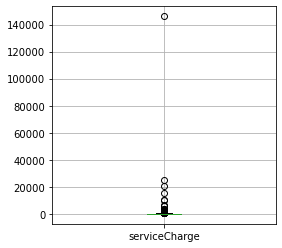

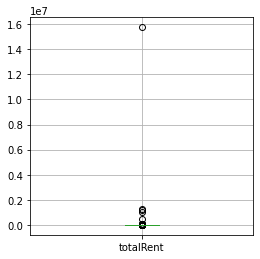

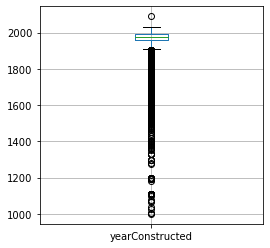

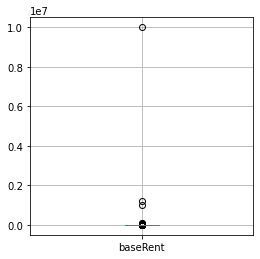

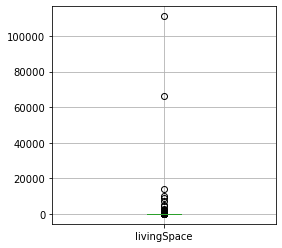

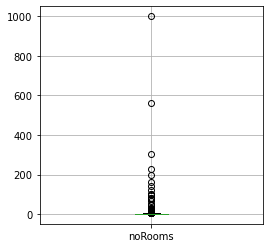

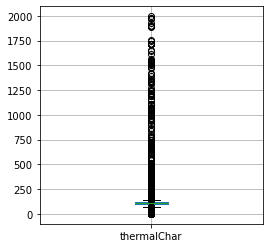

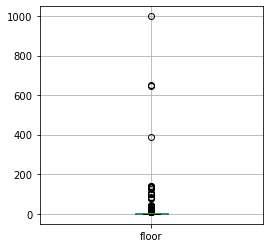

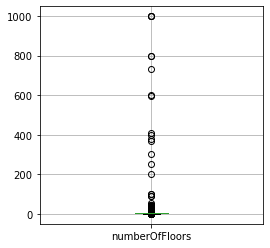

In [24]:
for col in outliers:
    plt.figure(figsize=(4, 4))
    df_p.boxplot(column=[col])

In [25]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [26]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df_p[col])[0])}')

serviceCharge: 10271
totalRent: 20025
yearConstructed: 23891
baseRent: 14458
livingSpace: 11459
noRooms: 8061
thermalChar: 64426
floor: 3241
numberOfFloors: 23251


In [28]:
for i in outliers:
    quartile_1, quartile_3 = np.percentile(df_p[i], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df_p = df_p[df_p[i]<upper_bound]
    df_p = df_p[df_p[i]>lower_bound]

In [29]:
def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [30]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df_p[col])[0])}')

serviceCharge: 726
totalRent: 757
yearConstructed: 0
baseRent: 560
livingSpace: 0
noRooms: 0
thermalChar: 0
floor: 0
numberOfFloors: 0


In [31]:
for i in ["serviceCharge", "totalRent", "baseRent"]:
    mean_y = np.mean(df_p[i])
    stdev_y = np.std(df_p[i])
    lower_bound = mean_y - (3 * stdev_y)
    upper_bound = mean_y + (3 * stdev_y)
    df_p = df_p[df_p[i]<upper_bound]
    df_p = df_p[df_p[i]>lower_bound]

In [32]:
df_p = df_p[df_p.yearConstructed < 2020]

<a id="Features"></a>
# Features

In [60]:
df = df_p.copy()

In [61]:
# Split numeric and non numeric columns
cat_df = df.select_dtypes(include=['object'])
num_df = df.select_dtypes(exclude=['object'])
print("non numeric:", cat_df.columns)
print("numeric:", num_df.columns)

non numeric: Index(['regio1', 'heatingType', 'telekomTvOffer', 'firingTypes', 'geo_bln',
       'houseNumber', 'geo_krs', 'condition', 'street', 'streetPlain',
       'typeOfFlat', 'regio2', 'regio3', 'description', 'facilities', 'date'],
      dtype='object')
numeric: Index(['serviceCharge', 'newlyConst', 'balcony', 'picturecount', 'pricetrend',
       'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'scoutId',
       'hasKitchen', 'cellar', 'yearConstructedRange', 'baseRent',
       'livingSpace', 'lift', 'baseRentRange', 'geo_plz', 'noRooms',
       'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden',
       'livingSpaceRange'],
      dtype='object')


In [37]:
df.head(1)

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,date
2,Sachsen,255.0,floor_heating,ONE_YEAR_FREE,True,True,8,2.72,2.4,1300.0,2019.0,113147523,gas,False,Sachsen,True,9.0,965.0,4,83.8,Dresden,first_time_use,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,107.0,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",Oct19


## regio1

In [38]:
df.regio1.value_counts()

Nordrhein_Westfalen       34490
Sachsen                   32591
Sachsen_Anhalt            13376
Bayern                     9204
Niedersachsen              8394
Baden_Württemberg          7628
Hessen                     7579
Thüringen                  5249
Rheinland_Pfalz            4590
Mecklenburg_Vorpommern     4403
Brandenburg                4296
Schleswig_Holstein         3125
Berlin                     2853
Bremen                     1630
Hamburg                    1115
Saarland                    808
Name: regio1, dtype: int64

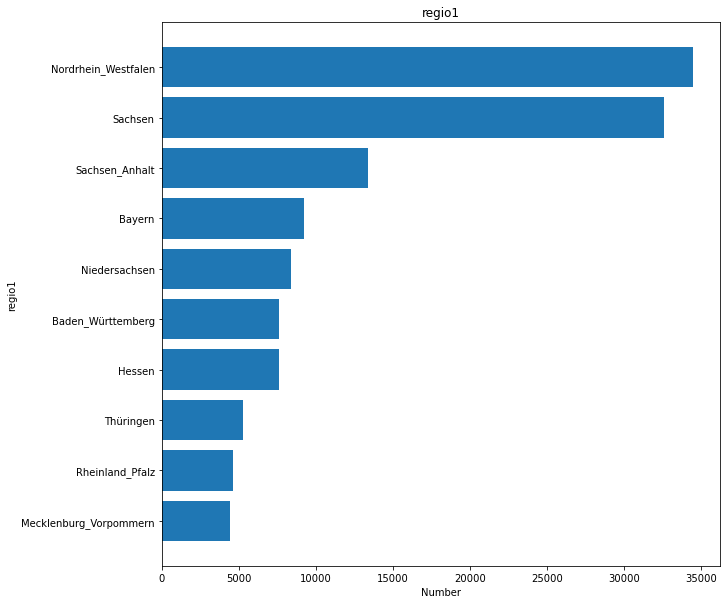

In [39]:
plt.figure(figsize=(10, 10))
data = df.regio1.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("regio1")
plt.ylabel("regio1")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## regio2

In [67]:
df.regio2.value_counts()

Chemnitz                        7575
Leipzig                         6828
Dresden                         3381
Berlin                          2853
Magdeburg                       2838
                                ... 
Freyung_Grafenau_Kreis            13
Memmingen                         12
Lichtenfels_Kreis                 11
Neustadt_a.d._Waldnaab_Kreis       9
Kronach_Kreis                      6
Name: regio2, Length: 419, dtype: int64

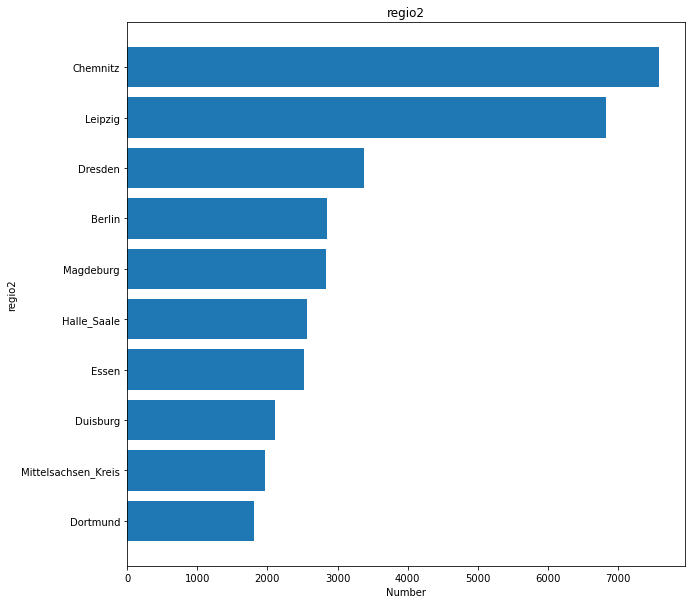

In [71]:
plt.figure(figsize=(10, 10))
data = df.regio2.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("regio2")
plt.ylabel("regio2")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## regio3

In [70]:
df.regio3.value_counts()

Innenstadt       2508
Stadtmitte       1393
Sonnenberg       1090
Altstadt         1045
Kaßberg           913
                 ... 
Kreuzwertheim       1
Großkorbetha        1
Neuensalz           1
Frauenkopf          1
Frettenheim         1
Name: regio3, Length: 7573, dtype: int64

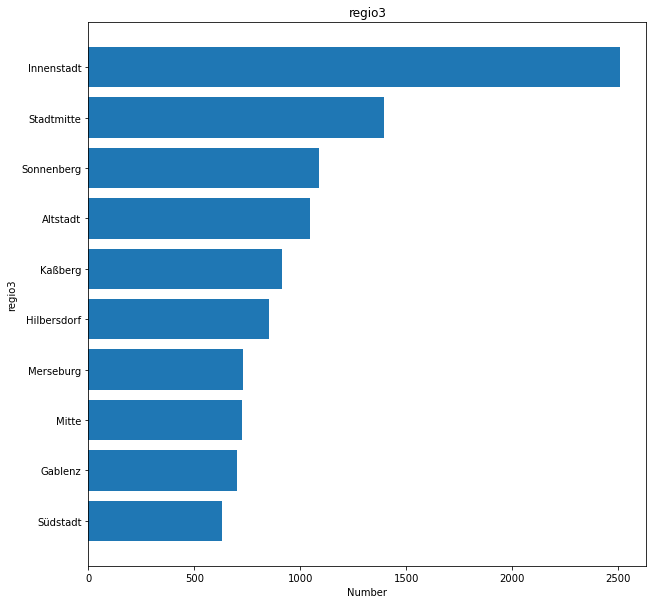

In [72]:
plt.figure(figsize=(10, 10))
data = df.regio3.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("regio3")
plt.ylabel("regio3")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## street

In [78]:
df.street.value_counts()

no_information                   33243
Hauptstra&szlig;e                  535
Bahnhofstra&szlig;e                474
Goethestra&szlig;e                 264
Berliner Stra&szlig;e              237
                                 ...  
Innere Bamberger Stra&szlig;e        1
Samuel- Frank- Str.                  1
Karl-Gr&uuml;n-Stra&szlig;e          1
Achenbacher Str.                     1
Emserstra&szlig;e                    1
Name: street, Length: 34395, dtype: int64

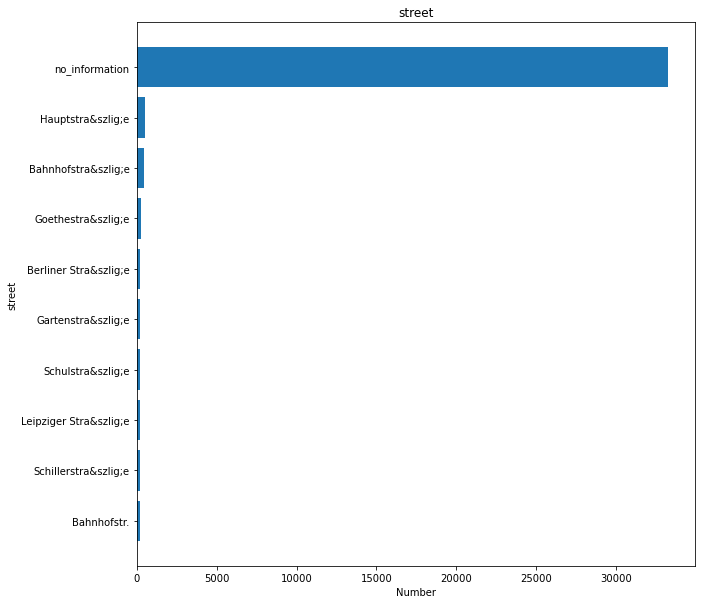

In [79]:
plt.figure(figsize=(10, 10))
data = df.street.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("street")
plt.ylabel("street")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## geo_krs

In [73]:
df.geo_krs.value_counts()

Chemnitz                        7575
Leipzig                         6828
Dresden                         3381
Berlin                          2853
Magdeburg                       2838
                                ... 
Freyung_Grafenau_Kreis            13
Memmingen                         12
Lichtenfels_Kreis                 11
Neustadt_a.d._Waldnaab_Kreis       9
Kronach_Kreis                      6
Name: geo_krs, Length: 419, dtype: int64

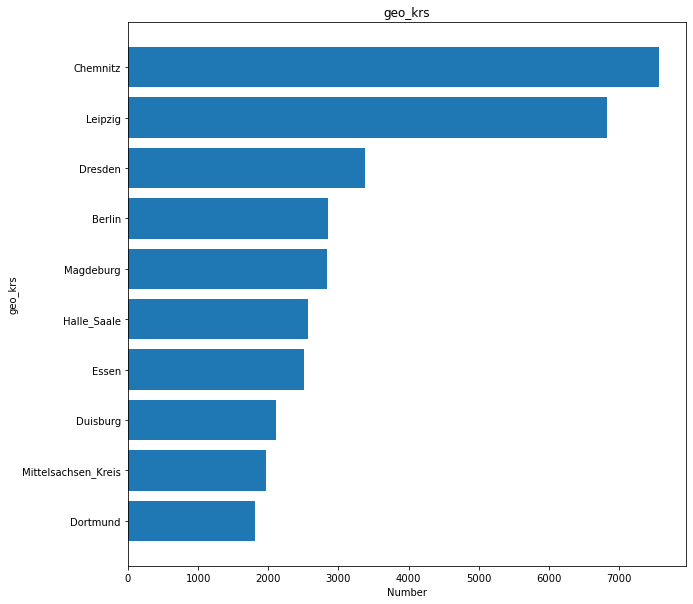

In [74]:
plt.figure(figsize=(10, 10))
data = df.geo_krs.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("geo_krs")
plt.ylabel("geo_krs")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## geo_bln

In [76]:
df.geo_bln.value_counts()

Nordrhein_Westfalen       34490
Sachsen                   32591
Sachsen_Anhalt            13376
Bayern                     9204
Niedersachsen              8394
Baden_Württemberg          7628
Hessen                     7579
Thüringen                  5249
Rheinland_Pfalz            4590
Mecklenburg_Vorpommern     4403
Brandenburg                4296
Schleswig_Holstein         3125
Berlin                     2853
Bremen                     1630
Hamburg                    1115
Saarland                    808
Name: geo_bln, dtype: int64

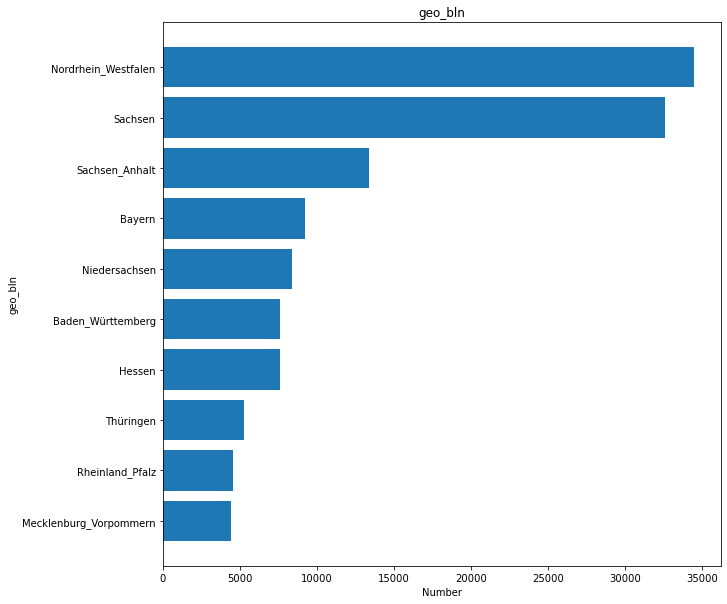

In [77]:
plt.figure(figsize=(10, 10))
data = df.geo_bln.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("geo_bln")
plt.ylabel("geo_bln")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## typeOfFlat

In [62]:
df.typeOfFlat.value_counts()

apartment              88904
roof_storey            20017
ground_floor           16644
other                   5703
maisonette              3277
raised_ground_floor     3221
half_basement           1387
terraced_flat           1364
penthouse                533
loft                     281
Name: typeOfFlat, dtype: int64

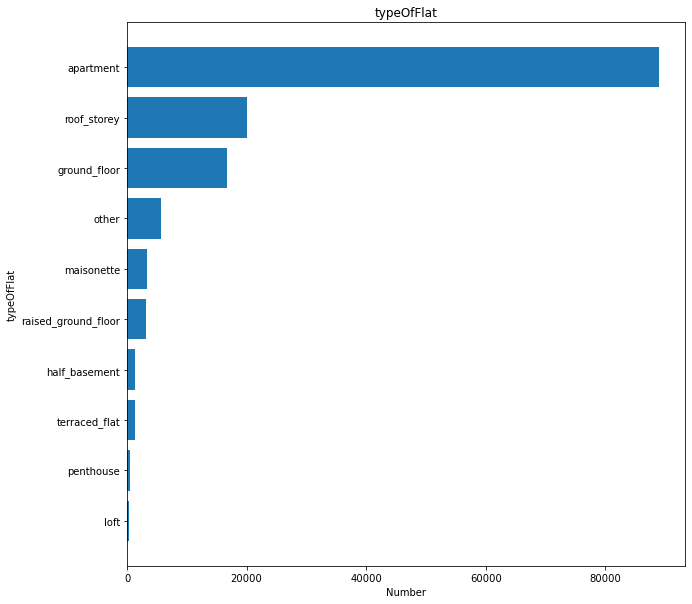

In [41]:
plt.figure(figsize=(10, 10))
data = df.typeOfFlat.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("typeOfFlat")
plt.ylabel("typeOfFlat")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

In [42]:
def filter(x):
    if x in [
    'maisonette', 'raised_ground_floor', 'half_basement', 'terraced_flat', 
    'penthouse', 'loft',
] :
        x = 'other'
        return x
    else:
        return x
df.typeOfFlat = df.typeOfFlat.apply(filter)

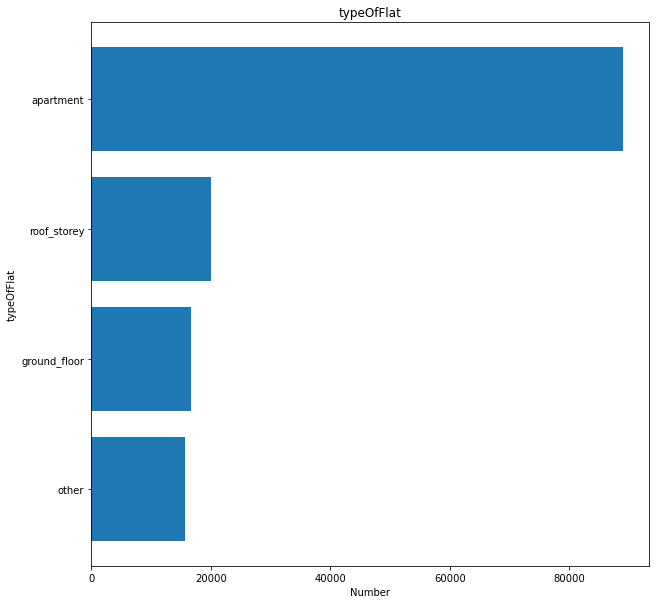

In [45]:
plt.figure(figsize=(10, 10))
data = df.typeOfFlat.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("typeOfFlat")
plt.ylabel("typeOfFlat")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## streetPlain

In [46]:
df.streetPlain.value_counts()[:10]

Hauptstraße         33762
Bahnhofstraße         463
Goethestraße          257
Berliner_Straße       236
Gartenstraße          226
Leipziger_Straße      214
Schulstraße           213
Bahnhofstr.           211
Schillerstraße        207
Ringstraße            176
Name: streetPlain, dtype: int64

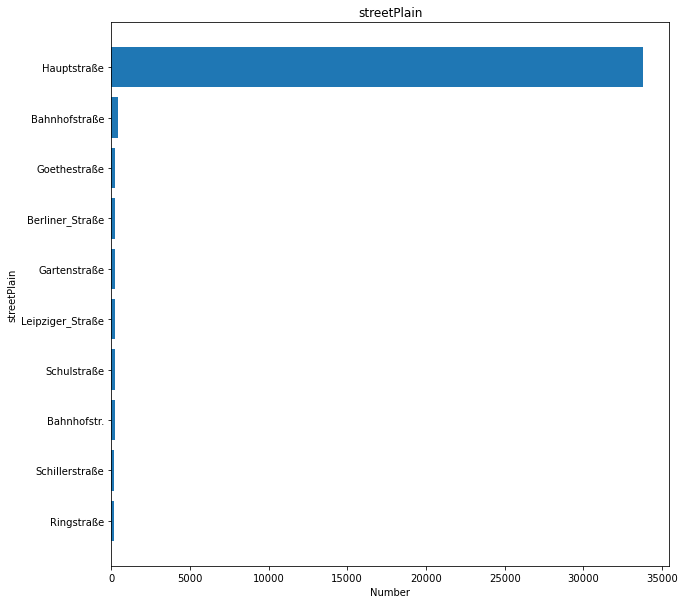

In [47]:
plt.figure(figsize=(10, 10))
data = df.streetPlain.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("streetPlain")
plt.ylabel("streetPlain")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## condition

In [48]:
df.condition.value_counts()

well_kept                             77639
refurbished                           15376
fully_renovated                       14565
modernized                             9699
mint_condition                         8487
first_time_use_after_refurbishment     7361
first_time_use                         6156
negotiable                             1287
need_of_renovation                      758
ripe_for_demolition                       3
Name: condition, dtype: int64

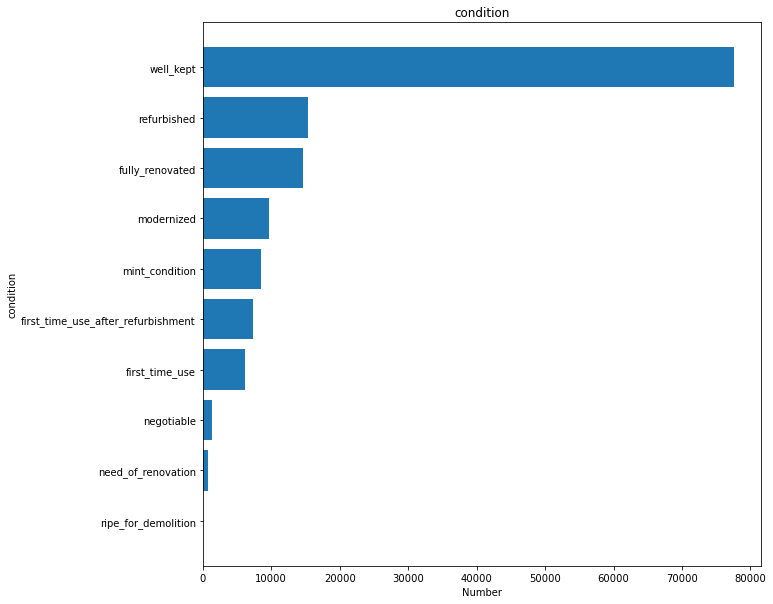

In [49]:
plt.figure(figsize=(10, 10))
data = df.condition.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("condition")
plt.ylabel("condition")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

In [50]:
def filter(x):
    if x in [
    "negotiable"                            ,
"need_of_renovation"                  ,
"ripe_for_demolition"                     ,
] :
        x = 'other'
        return x
    else:
        return x
df.condition = df.condition.apply(filter)

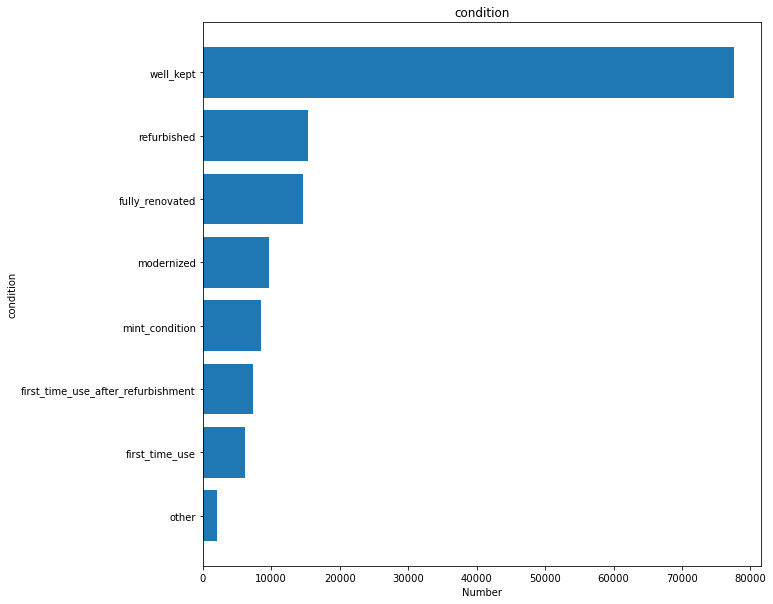

In [51]:
plt.figure(figsize=(10, 10))
data = df.condition.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("condition")
plt.ylabel("condition")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## firingTypes

In [52]:
df.firingTypes.value_counts()[:10]

gas                  91499
district_heating     25605
oil                   9590
natural_gas_light     4971
electricity           2376
natural_gas_heavy     2203
pellet_heating        1019
geothermal             681
gas:electricity        607
local_heating          414
Name: firingTypes, dtype: int64

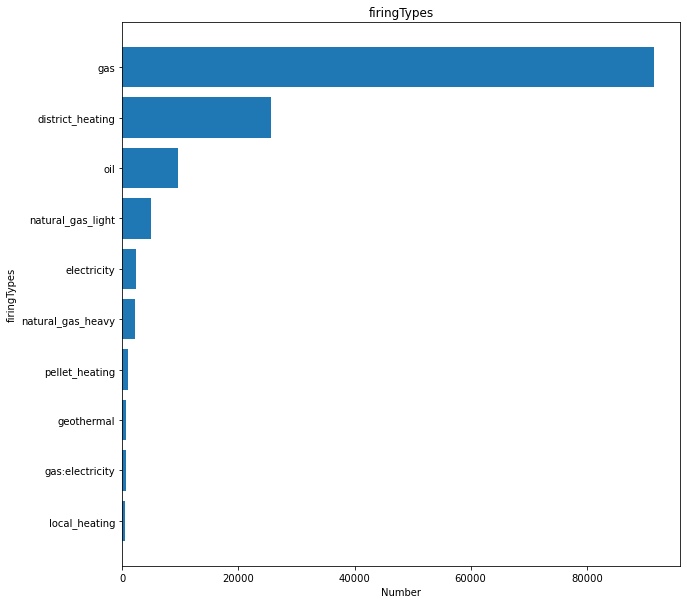

In [53]:
plt.figure(figsize=(10, 10))
data = df.firingTypes.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("firingTypes")
plt.ylabel("firingTypes")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## heatingType

In [54]:
df.heatingType.value_counts()

central_heating                   94906
district_heating                  13965
gas_heating                       11436
self_contained_central_heating     9115
floor_heating                      5507
oil_heating                        2864
night_storage_heater                861
heat_pump                           768
combined_heat_and_power_plant       711
electric_heating                    545
wood_pellet_heating                 428
stove_heating                       168
solar_heating                        57
Name: heatingType, dtype: int64

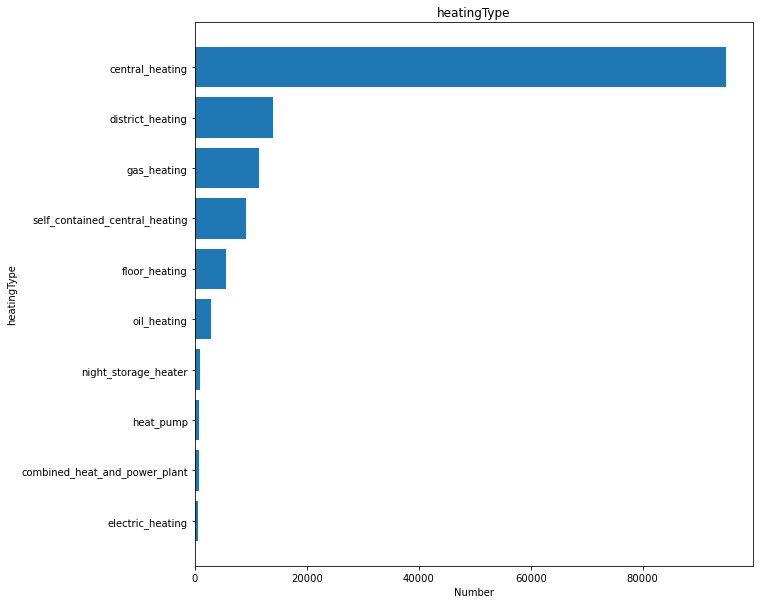

In [55]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

In [56]:
def filter(x):
    if x in [
    'oil_heating', 'combined_heat_and_power_plant', 'heat_pump', 'night_storage_heater', 
    'wood_pellet_heating', 'electric_heating', 'stove_heating', 'solar_heating'
] :
        x = 'other'
        return x
    else:
        return x
df.heatingType = df.heatingType.apply(filter)

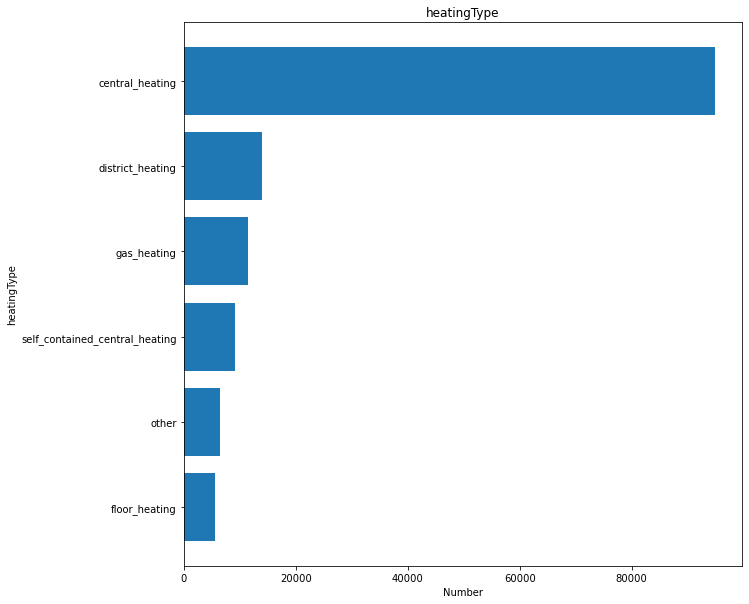

In [57]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

## telekomTvOffer

In [58]:
df.telekomTvOffer.value_counts()

ONE_YEAR_FREE    122356
NONE              16891
ON_DEMAND          2084
Name: telekomTvOffer, dtype: int64

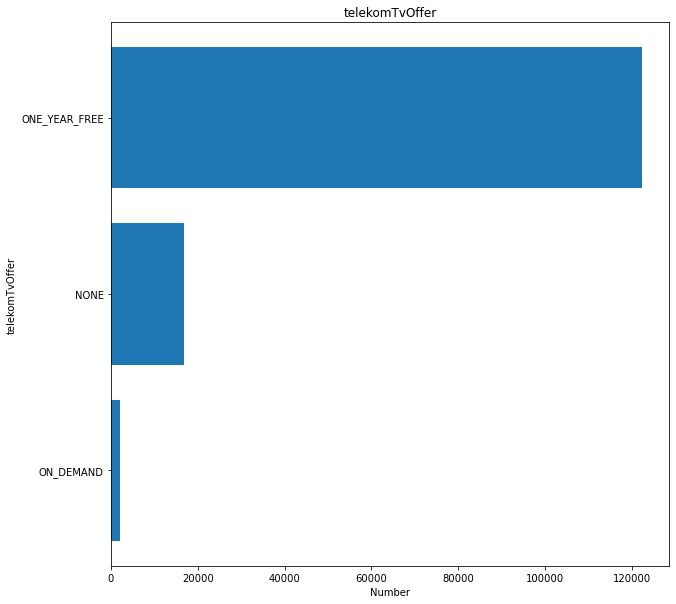

In [59]:
plt.figure(figsize=(10, 10))
data = df.telekomTvOffer.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("telekomTvOffer")
plt.ylabel("telekomTvOffer")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

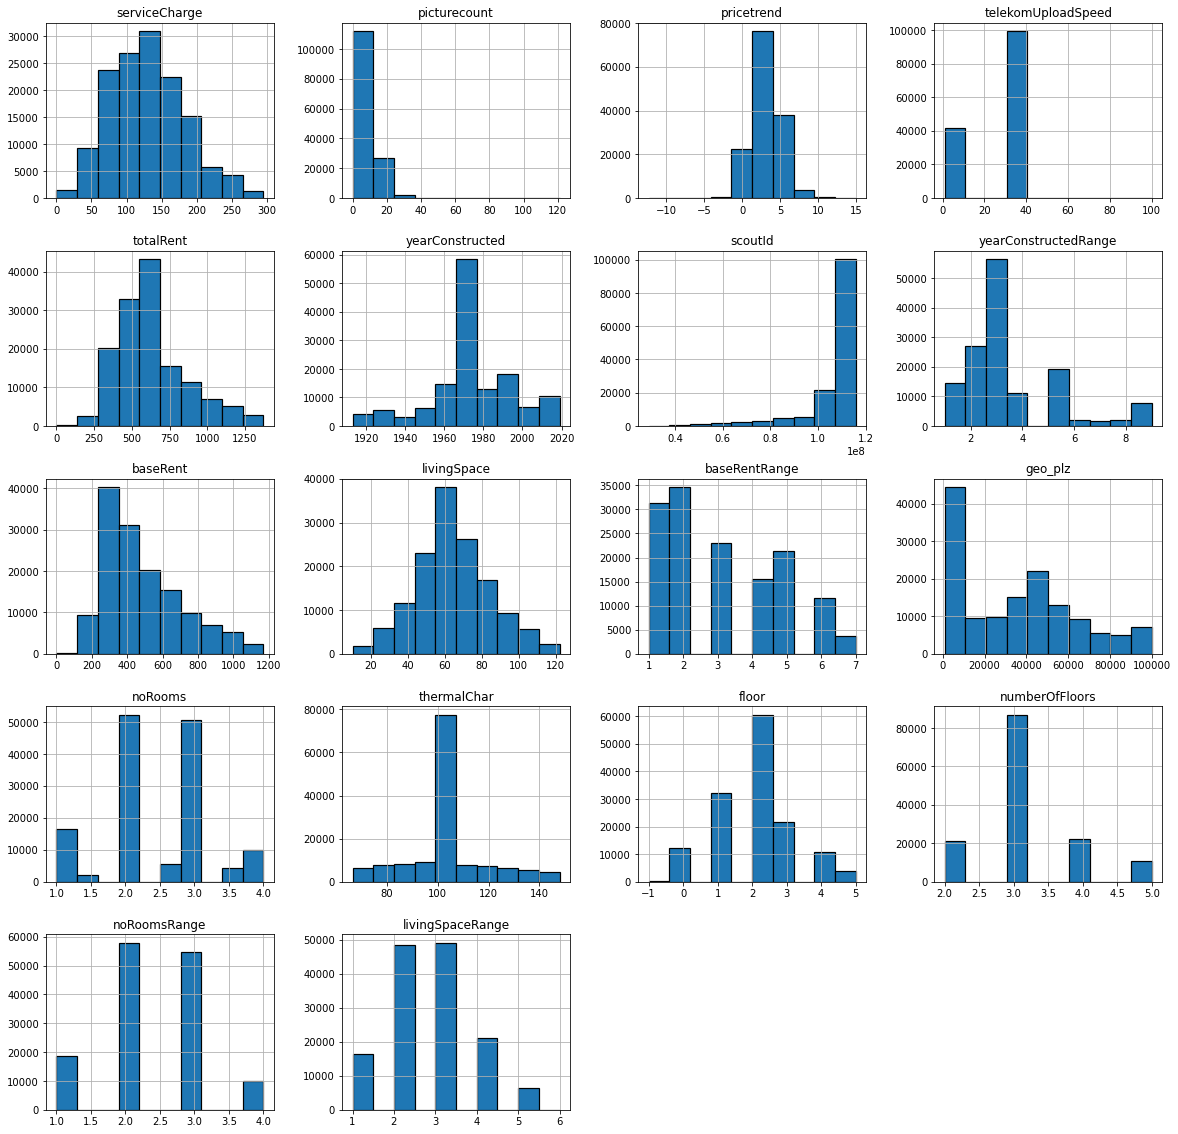

In [80]:
# Visualizing the distribution for every "feature"
df.hist(edgecolor="black", linewidth=1.2, figsize=(20, 20))
plt.show()

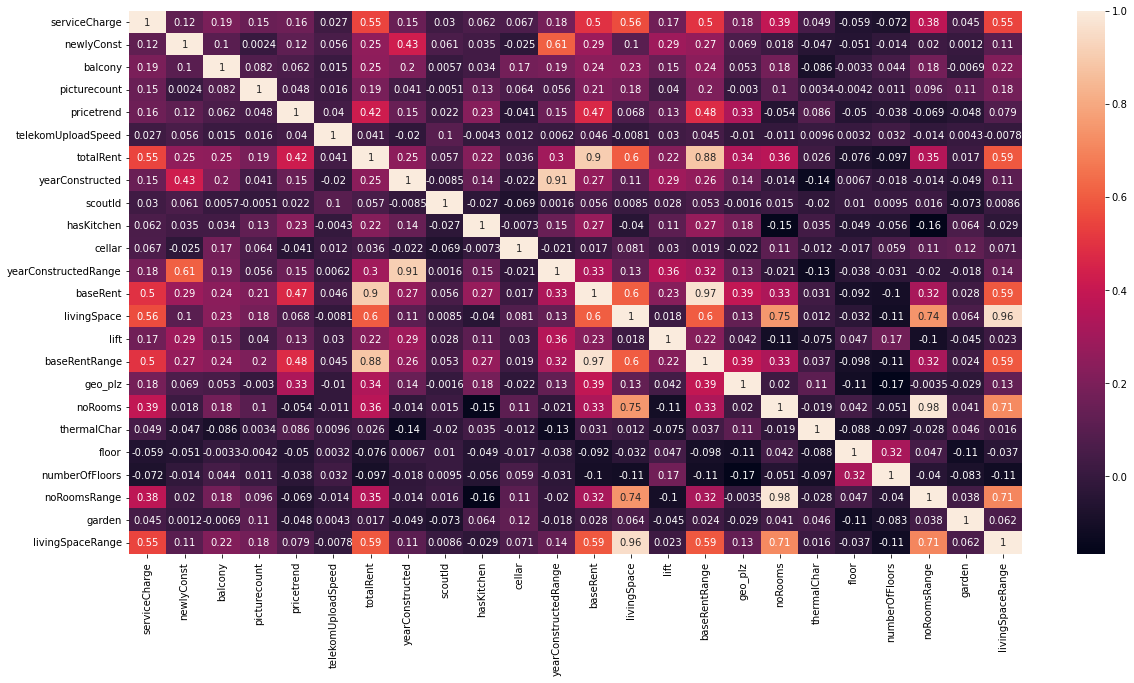

In [81]:
# correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()